In [4]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [5]:
def load_dataset(root_dir):
    """
    Load dataset from a root directory where each folder contains 3 images:
    frame1 (start), frame2 (middle), frame3 (end).
    
    Args:
        root_dir (str): Path to the root directory containing folders of images.
        
    Returns:
        list of dict: Each dict contains the paths for start, middle, and end frames.
    """
    dataset = []
    
    # Iterate over each folder in the root directory
    for folder_name in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder_name)
        
        # Ensure it's a directory
        if os.path.isdir(folder_path):
            # Define paths for frame1, frame2, and frame3
            frame1_path = os.path.join(folder_path, "frame1.jpg")
            frame2_path = os.path.join(folder_path, "frame2.jpg")
            frame3_path = os.path.join(folder_path, "frame3.jpg")
            
            # Check if all three frames exist
            if all(os.path.exists(path) for path in [frame1_path, frame2_path, frame3_path]):
                dataset.append({
                    "start": frame1_path,
                    "middle": frame2_path,
                    "end": frame3_path
                })
            else:
                print(f"Warning: Missing frames in {folder_path}")
    
    return dataset
    


In [6]:
root_dir = "datasets/train_10k"
dataset = load_dataset(root_dir)
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: True


In [7]:

class FrameDataset(Dataset):
    def __init__(self, dataset, transform=None):
        """
        Dataset for loading start, middle, and end frames.
        
        Args:
            dataset (list of dict): List of paths for start, middle, and end frames.
            transform (callable, optional): Transformations to apply to images.
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        
        # Load images
        start_img = Image.open(data["start"]).convert("RGB")
        middle_img = Image.open(data["middle"]).convert("RGB")
        end_img = Image.open(data["end"]).convert("RGB")
        
        # Apply transforms if available
        if self.transform:
            start_img = self.transform(start_img)
            middle_img = self.transform(middle_img)
            end_img = self.transform(end_img)
        
        return start_img, middle_img, end_img


In [8]:

import torch
import torch.nn as nn
from torchvision.models import resnet18

class AnimationTransformer(nn.Module):
    def __init__(self, d_model=256, num_heads=4, num_layers=9):
        super(AnimationTransformer, self).__init__()
        # CNN backbone for feature extraction
        self.cnn_backbone = resnet18(pretrained=True)
        self.cnn_backbone.fc = nn.Identity()  # Remove classification head

        # Projection layer to match Transformer input size
        self.feature_projection = nn.Linear(512, d_model)

        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=num_heads, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Decoder layers to reconstruct image
        self.decoder_fc = nn.Linear(d_model, d_model * 4 * 4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(d_model, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),        # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),        # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=4, padding=0),         # 32x32 -> 128x128
            nn.Sigmoid()  # Normalize to [0, 1]
        )

    def forward(self, start_frame, end_frame):
        # Extract features from start and end frames
        start_features = self.cnn_backbone(start_frame)
        end_features = self.cnn_backbone(end_frame)
        
        # Project features to match Transformer input dimensions
        start_features = self.feature_projection(start_features)
        end_features = self.feature_projection(end_features)
        
        # Concatenate start and end features
        combined_features = torch.stack([start_features, end_features], dim=1)
        
        # Pass through Transformer
        transformed_features = self.transformer(combined_features)
        
        # Decode features to reconstruct the middle frame
        middle_features = transformed_features[:, 0, :]  # Use the first token
        middle_features = self.decoder_fc(middle_features)
        middle_features = middle_features.view(middle_features.size(0), -1, 4, 4)
        reconstructed_frame = self.deconv(middle_features)
        return reconstructed_frame


In [9]:

# Hyperparameters
batch_size = 128
learning_rate = 1e-4
num_epochs = 50

# Data preparation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = FrameDataset(dataset, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AnimationTransformer().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Tracking loss and accuracy
epoch_losses = []
epoch_accuracies = []

print("Device : ",device)
# Accuracy function
def calculate_accuracy(predictions, targets):
    """
    Calculate pixel-wise accuracy for the predicted and target frames.
    """
    correct = (torch.argmax(predictions, dim=1) == torch.argmax(targets, dim=1)).float().sum()
    total = targets.numel()
    return correct / total


/home/pcn/Desktop/Rafey/In-Between-Frame-Generation/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pcn/Desktop/Rafey/In-Between-Frame-Generation/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/pcn/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 11.3MB/s]


Device :  cuda


In [10]:

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for start_img, middle_img, end_img in train_loader:
        # Move data to GPU
        start_img = start_img.to(device)
        middle_img = middle_img.to(device)
        end_img = end_img.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        predicted_middle = model(start_img, end_img)
        
        # Compute loss
        loss = criterion(predicted_middle, middle_img)
        running_loss += loss.item()
        
        # Compute accuracy
        accuracy = calculate_accuracy(predicted_middle, middle_img)
        running_accuracy += accuracy.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)
    
    # Save checkpoint
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
        'accuracy': epoch_accuracy,
    }
    if epoch % 5 == 0:
        checkpoint_path = f"Animationcheckpoints/checkpoint_epoch_{epoch+1}.pth"
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")
    
    # Logging
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

print("Training complete!")


Checkpoint saved: Animationcheckpoints/checkpoint_epoch_1.pth
Epoch [1/50], Loss: 0.0803, Accuracy: 0.1280
Epoch [2/50], Loss: 0.0495, Accuracy: 0.1308
Epoch [3/50], Loss: 0.0430, Accuracy: 0.1335
Epoch [4/50], Loss: 0.0403, Accuracy: 0.1345
Epoch [5/50], Loss: 0.0392, Accuracy: 0.1351
Checkpoint saved: Animationcheckpoints/checkpoint_epoch_6.pth
Epoch [6/50], Loss: 0.0387, Accuracy: 0.1354
Epoch [7/50], Loss: 0.0386, Accuracy: 0.1378
Epoch [8/50], Loss: 0.0380, Accuracy: 0.1425
Epoch [9/50], Loss: 0.0350, Accuracy: 0.1478
Epoch [10/50], Loss: 0.0316, Accuracy: 0.1500
Checkpoint saved: Animationcheckpoints/checkpoint_epoch_11.pth
Epoch [11/50], Loss: 0.0310, Accuracy: 0.1537
Epoch [12/50], Loss: 0.0298, Accuracy: 0.1637
Epoch [13/50], Loss: 0.0286, Accuracy: 0.1881
Epoch [14/50], Loss: 0.0277, Accuracy: 0.2071
Epoch [15/50], Loss: 0.0268, Accuracy: 0.2163
Checkpoint saved: Animationcheckpoints/checkpoint_epoch_16.pth
Epoch [16/50], Loss: 0.0257, Accuracy: 0.2200
Epoch [17/50], Loss: 0.

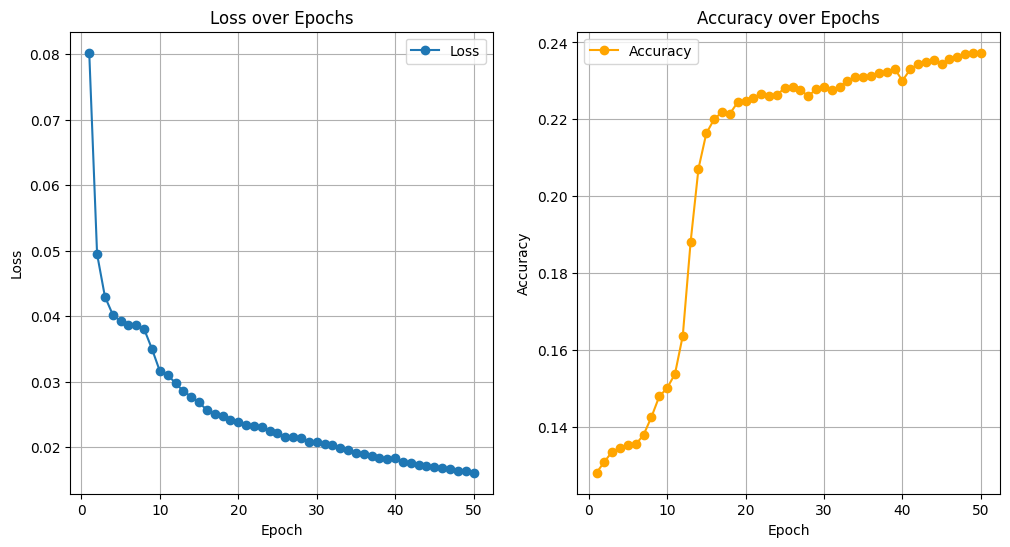

In [11]:

# Save loss and accuracy plots
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), epoch_accuracies, marker='o', color='orange', label='Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Save and display plots
plt.savefig("training_metrics.png")
plt.show()


In [12]:

torch.save(model.state_dict(), "animation_transformer.pth")

/tmp/ipykernel_109385/3062179087.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("animation_transformer.pth"))


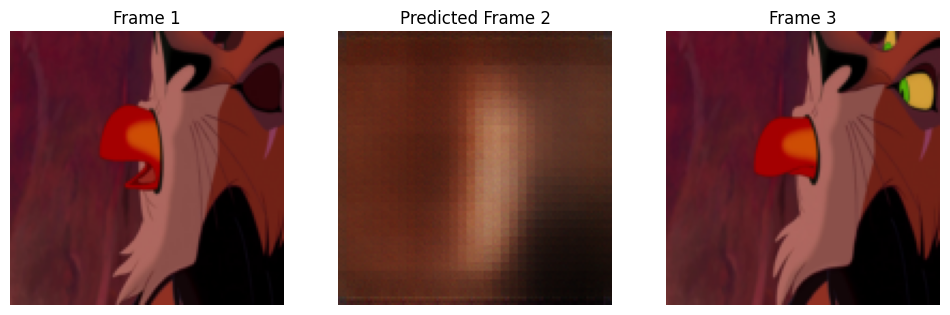

In [15]:

# Testing
frame1 = Image.open("/home/pcn/Desktop/Rafey/In-Between-Frame-Generation/datasets/test_2k_540p/Disney_v4_0_000249_s2/frame1.png").convert("RGB")
frame3 = Image.open("/home/pcn/Desktop/Rafey/In-Between-Frame-Generation/datasets/test_2k_540p/Disney_v4_0_000249_s2/frame3.png").convert("RGB")

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

frame1 = transform(frame1).unsqueeze(0)
frame3 = transform(frame3).unsqueeze(0)

model = AnimationTransformer()
model.load_state_dict(torch.load("animation_transformer.pth"))
model.eval()

with torch.no_grad():
    predicted_frame = model(frame1, frame3)

plt.figure(figsize=(12, 6))

# Original frames
plt.subplot(1, 3, 1)
plt.imshow(transforms.ToPILImage()(frame1[0]))
plt.title("Frame 1")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(transforms.ToPILImage()(predicted_frame[0]))
plt.title("Predicted Frame 2")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(transforms.ToPILImage()(frame3[0]))
plt.title("Frame 3")
plt.axis('off')

plt.savefig("test_results.png")
plt.show()


In [14]:
# finding the MSE score using test data 
root_dir = "datasets/test_2k_original"
test_dataset = load_dataset(root_dir)
test_dataset = test_dataset[:100]

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

test_dataset = FrameDataset(test_dataset, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = AnimationTransformer()
model.load_state_dict(torch.load("animation_transformer.pth"))

criterion = nn.MSELoss()
model.eval()

test_losses = []

for start_img, middle_img, end_img in test_loader:
    with torch.no_grad():
        predicted_middle = model(start_img, end_img)
        loss = criterion(predicted_middle, middle_img)
        test_losses.append(loss.item())

test_loss = sum(test_losses) / len(test_losses)
print(f"Test Loss: {test_loss:.4f}")

/tmp/ipykernel_109385/671877177.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("animation_transformer.pth"))


Test Loss: 0.0172
